<a href="https://colab.research.google.com/github/LcsCunha/Treinos-de-Python/blob/main/Teste_2_Transforma%C3%A7%C3%A3o_de_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarefas de código:
    - Extrair do pdf do teste 1 os dados dos Quadros 30,31,32 (Tabela de categoria do Padrão TISS);
    - Salvar dados em tabelas estruturadas, em csvs;
    - Zipar todos os csvs num arquivo "Teste_Intuitive_Care_{seu_nome}.zip".


In [ ]:
!pip install kaggle
!pip install fitz
!pip install PyMuPDF
!pip install tabula-py
!pip install pandas
!pip install xlwt

##Pegando o arquivo pdf com as tabelas

In [2]:
#Também poderia ser efetuado utilizando o código do teste 1
#Nesse caso utilizei a API de um site chamado Kaggle, onde posso armazenar dados para pegá-los de forma automática com Python
import os

os.environ['KAGGLE_USERNAME'] = "lucascunhadecarvalho"
os.environ['KAGGLE_KEY'] = "66aee9f83fd989281d28d8832f428c68"

!kaggle datasets download -d lucascunhadecarvalho/teste-intuitive-care #Link para o kaggle: https://www.kaggle.com/lucascunhadecarvalho/teste-intuitive-care
!unzip -q teste-intuitive-care

  0% 0.00/2.12M [00:00<?, ?B/s]
100% 2.12M/2.12M [00:00<00:00, 70.9MB/s]


In [ ]:
#Printando uma parte específica procurando as tabelas no pdf
import fitz  # this is pymupdf

pdf = "padrao_tiss_componente_organizacional_202108.pdf" #Variável que guardará o caminho para o arquivo pdf

with fitz.open(pdf) as doc: 
    text = ""
    for page in doc:
        text += page.getText()
        #Procurei encontrar a página onde começa o quadro 30, buscando pela dada palavra chave dentro do if
        if "Tabela de categoria do Padrão TISS" in text: 
          break

print(text) #printando o texto do pdf para análise

In [ ]:
#Encontradas as tabelas, isolei os trechos do pdf (páginas) que contém apenas as tabelas
with fitz.open(pdf) as doc:
    text = ""
    for page in doc:
        text += page.getText()
        #Com as tabelas encontradas, busquei o número das páginas onde encontram-se as tabelas
        if "Quadro 32 – Tabela de tipo de solicitação" in text:
          tabelas = text.index("Quadro 30 – Tabela de tipo de demandante")
          text = text[tabelas:]
          tabelas = text.index("Exclusão ") + len("Exclusão ")
          text = text[:tabelas]
          break

print(text) #Printando o texto para análise

In [ ]:
#Encontrando as páginas e a partir da análise dos outputs anteriores, pude pegar as tabelas utilizando tabula e pandas
import tabula
import pandas as pd

tabela30 = tabula.read_pdf(pdf, pages='108') #Lendo tabelas página por página como listas
print(tabela30[0]) #Printando a tabela 30 para análise

#Como a tabela 31 se extende por mais páginas, foi necessário guardar as listas resultantes em uma lista
tabela31 = []
for pagina in range(109, 115): 
  tabela31.append(tabula.read_pdf(pdf, pages=str(pagina)))

print(tabela31)

#Tabula pega todas as tabelas de uma mesma página e as guarda em uma lista
tabela32 = tabula.read_pdf(pdf, pages='114')
#Como na página 114 existem 2 tabelas: parte da tabela 31 e a tabela 32, a tabela 32 fica armazenada no segundo index
print(tabela32[1])

In [6]:
#Salvando as tabelas em csv
tabela30[0].to_csv("tabela30.csv", encoding='utf-8-sig')

for pagina in tabela31:
    pagina[0].to_csv("tabela31.csv", mode='a', encoding='utf-8-sig')

tabela32[1].to_csv("tabela32.csv", encoding='utf-8-sig')


No código anterior, os arquivos foram salvos como csv, porém com as suas células "grudadas":

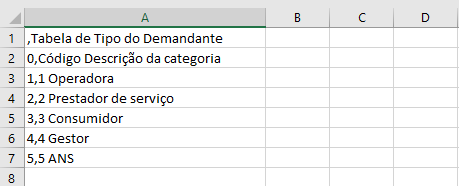

O decorrer deste código será uma manipulação desses csvs para melhor vizualização de células e correção de algumas distorções de formatação causadas pelo tabula

In [12]:
#Organizando os arquivos csv
import csv
from xlwt import Workbook 

def readCSV (arquivoTabela):
  """
  Função criada com o intuito de ler um arquivo csv e
  retornar seus elementos (dados) como forma de lista de strings
  """
  with open(arquivoTabela, newline='') as f:
      reader = csv.reader(f)
      dados = list(reader)

  return dados

def geraCSV (nomeFinalArquivo, dados):
  """
  Função criada com o intuito de manipular uma determinada
  lista de string e organizá-la em um arquivo csv formando uma tabela desejada,
  com sua devida formatação de células
  """
  codigos = []
  descricoes = []

  for valor in dados:
    dado = valor[1].split(' ', 1)
    codigos.append(dado[0]) 
    descricoes.append(dado[1])

  #Criando um dataframe utilizando pandas para a vizualização das tabelas
  data = {'Código':  codigos,
          'Descrição da categoria': descricoes,
         }

  df = pd.DataFrame(data)

  print (df) #Printando a tabela para vizualização

  #Utilizando Workbook para escrever os conteúdos das tabelas em diferentes células
  wb = Workbook()
  tabela = wb.add_sheet('Tabela')
  tabela.write(0, 0, 'Código')
  tabela.write(0, 1, 'Descrição da categoria')

  for linha in range(len(codigos)):
    tabela.write(linha+1, 0, int(codigos[linha]))
    tabela.write(linha+1, 1, descricoes[linha])

  wb.save(nomeFinalArquivo + 'xlsx') 
  data_xls = pd.read_excel(nomeFinalArquivo + 'xlsx', 'Tabela', index_col=None)
  data_xls.to_csv(nomeFinalArquivo + ".csv", sep=';',encoding='utf-8-sig', index=False)

In [13]:
#Realizando pré-processamento das tabelas de acordo com como tabula retornou as tabelas, para então gerar o CSV final
dados = readCSV("tabela30.csv")
#Pré-processamento do quadro 30
print(dados) #Printando a lista para análise
dados = dados[2:]
geraCSV("Quadro30", dados)

dados = readCSV("tabela31.csv")
#Pré-processamento do quadro 31
print(dados) #Printando a lista para análise
dados = dados[2:]

index = 0
paraRemover = []

for dado in dados:
  try:
    dado[1] = dado[1] + ' ' + dado[2]
  except Exception as e:
    dados[index - 1][1] += (" " + dado[0]) #Corrigindo um problema de formatação do quadro 31
    paraRemover.append(index)

  index += 1

for i in range(len(paraRemover) - 1, -1, -1): #Corrigindo um problema de formatação do quadro 31
  dados.pop(paraRemover[i])

geraCSV("Quadro31", dados)

dados = readCSV("tabela32.csv")
#Pré-processamento do quadro 31
print(dados) #Printando a lista para análise
dados = dados[3:]
dados.pop(2) #Corrigindo um problema de formatação do quadro 32

geraCSV("Quadro32", dados)

[['\ufeff', 'Tabela de Tipo do Demandante'], ['0', 'Código Descrição da categoria'], ['1', '1 Operadora'], ['2', '2 Prestador de serviço'], ['3', '3 Consumidor'], ['4', '4 Gestor'], ['5', '5 ANS']]
  Código Descrição da categoria
0      1              Operadora
1      2   Prestador de serviço
2      3             Consumidor
3      4                 Gestor
4      5                    ANS
[['\ufeff', 'Unnamed: 0', 'Tabela de Categoria do Padrão TISS'], ['0', 'Código', 'Descrição da categoria'], ['1', '1', 'Componente Organizacional'], ['2', '2', 'Componente de Conteúdo e Estrutura'], ['3', '3', 'Componente de Representação de Conceitos em Saúde'], ['4', '4', 'Componente de Comunicação'], ['5', '5', 'Componente de Segurança e Privacidade'], ['6', '18', 'Terminologia de diárias, taxas e gases medicinais'], ['7', '19', 'Terminologia de materiais e OPME'], ['8', '20', 'Terminologia de medicamentos'], ['9', '22', 'Terminologia de procedimentos e eventos em saúde'], ['10', '23', 'Terminologia 

In [14]:
#Zipando os arquivos csv

!zip -r Teste_Intuitive_Care_{Lucas-Cunha-de-Carvalho}.zip Quadro30.csv Quadro31.csv Quadro32.csv

updating: Quadro30.csv (deflated 4%)
updating: Quadro31.csv (deflated 74%)
updating: Quadro32.csv (deflated 12%)
